Dataset shape: (3000, 64, 64, 3) Labels: (3000,)


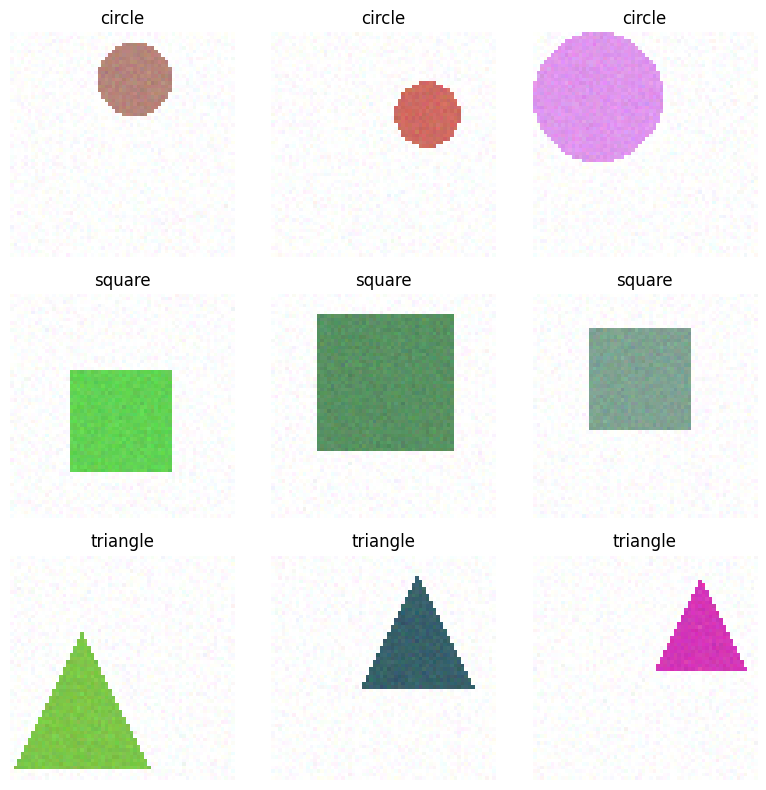

Train/Val/Test sizes: 1800 600 600


In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Settings
SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)

IMG_SIZE = 64
NUM_PER_CLASS = 1000
CLASSES = ["circle", "square", "triangle"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def draw_circle(draw, bbox, fill): draw.ellipse(bbox, fill=fill)
def draw_square(draw, bbox, fill): draw.rectangle(bbox, fill=fill)
def draw_triangle(draw, bbox, fill):
    x0, y0, x1, y1 = bbox
    cx, cy = (x0+x1)/2, (y0+y1)/2
    pts = [(cx, y0), (x0, y1), (x1, y1)]
    draw.polygon(pts, fill=fill)

def random_color(): return tuple(np.random.randint(30,240,3).tolist())
def random_bbox(img_size, min_rel=0.28, max_rel=0.75):
    s = np.random.uniform(min_rel, max_rel) * img_size
    w = h = int(s)
    x0 = np.random.randint(0, img_size - w)
    y0 = np.random.randint(0, img_size - h)
    return (x0, y0, x0+w, y0+h)

def add_light_noise(arr, sigma=6.0):
    noisy = arr.astype(np.float32) + np.random.normal(0,sigma,arr.shape)
    return np.clip(noisy,0,255).astype(np.uint8)

def generate_one(shape_label):
    img = Image.new("RGB",(IMG_SIZE,IMG_SIZE),(255,255,255))
    draw = ImageDraw.Draw(img)
    bbox = random_bbox(IMG_SIZE)
    fill = random_color()
    if shape_label=="circle": draw_circle(draw,bbox,fill)
    elif shape_label=="square": draw_square(draw,bbox,fill)
    else: draw_triangle(draw,bbox,fill)
    arr = np.array(img,dtype=np.uint8)
    arr = add_light_noise(arr)
    return arr

def generate_dataset(num_per_class=NUM_PER_CLASS):
    images, labels = [], []
    for idx, name in enumerate(CLASSES):
        for _ in range(num_per_class):
            images.append(generate_one(name))
            labels.append(idx)
    return np.stack(images), np.array(labels)

images, labels = generate_dataset(NUM_PER_CLASS)
print("Dataset shape:", images.shape, "Labels:", labels.shape)


def show_grid(samples, titles, nrow=3,ncol=3):
    plt.figure(figsize=(8,8))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(samples[i])
        plt.axis("off")
        if i<len(titles): plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# Pick 9 samples for preview
idxs=[]
for c in range(len(CLASSES)):
    idxs.extend(np.where(labels==c)[0][:3])
samples = images[idxs]
titles=[]
for c in range(len(CLASSES)): titles+=[CLASSES[c]]*3
show_grid(samples,titles)

class ShapeDataset(Dataset):
    def __init__(self, imgs, lbls, normalize=True):
        self.imgs = imgs
        self.lbls = lbls
        self.normalize = normalize
    def __len__(self): return len(self.lbls)
    def __getitem__(self, idx):
        x = self.imgs[idx].astype(np.float32)/255.0
        x = np.transpose(x,(2,0,1))
        y = int(self.lbls[idx])
        return torch.tensor(x), torch.tensor(y)

dataset = ShapeDataset(images, labels)
n_total=len(dataset)
n_train=int(0.6*n_total)
n_val=int(0.2*n_total)
n_test=n_total-n_train-n_val
train_set,val_set,test_set=random_split(dataset,[n_train,n_val,n_test],
                                        generator=torch.Generator().manual_seed(SEED))
def make_loader(ds,bs=64,shuffle=False): return DataLoader(ds,batch_size=bs,shuffle=shuffle)
train_loader = make_loader(train_set,bs=64,shuffle=True)
val_loader   = make_loader(val_set,bs=64,shuffle=False)
test_loader  = make_loader(test_set,bs=64,shuffle=False)
print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))


#  MLP Skeleton (fill in optimizer & experiments)

class MLP(nn.Module):
    def __init__(self,input_dim=IMG_SIZE*IMG_SIZE*3,hidden=128,num_classes=len(CLASSES)):
        super().__init__()
        self.net=nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim,hidden),
            nn.ReLU(),
            nn.Linear(hidden,num_classes)
        )
    def forward(self,x): return self.net(x)




In [23]:

def train_experiment(model, train_loader, val_loader, optimizer, epochs=10,
                     early_stopping=False, patience=3):
    """
    Returns a history dictionary containing loss and accuracy metrics.
    """
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    min_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = running_val_loss / val_total
        val_acc = val_correct / val_total

        # Log history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early Stopping Logic
        if early_stopping:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break
    print(f"Final Val Acc: {history['val_acc'][-1]:.5f}")
    return history

def plot_histories(histories, titles):
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for name, hist in zip(titles, histories):
        plt.plot(hist['val_loss'], label=name)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for name, hist in zip(titles, histories):
        plt.plot(hist['val_acc'], label=name)
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

--- Experiment 1: SGD (LR=0.2) ---
Final Val Acc: 0.35167

--- Experiment 2: SGD (LR=0.0001) ---
Final Val Acc: 0.38500

--- Experiment 3: SGD Momentum (LR=0.01, mom=0.9) ---
Final Val Acc: 0.32333

--- Experiment 4: Adam (LR=0.001) ---
Final Val Acc: 0.47500


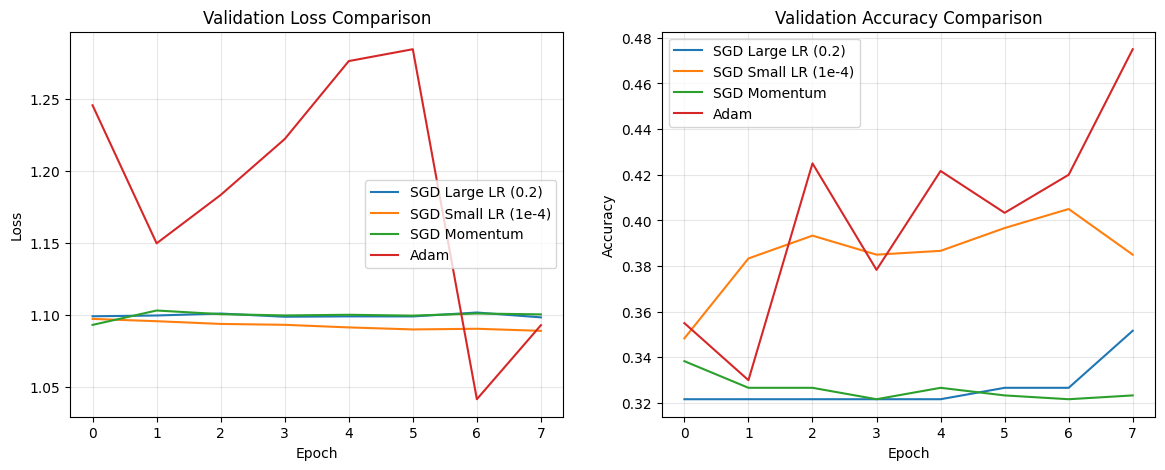

In [24]:
# Configurations
EPOCHS = 8
input_dim = IMG_SIZE * IMG_SIZE * 3
results = []
names = []

# 1. SGD Large LR
print("--- Experiment 1: SGD (LR=0.2) ---")
model = MLP(input_dim).to(DEVICE)
opt = optim.SGD(model.parameters(), lr=0.2)
res = train_experiment(model, train_loader, val_loader, opt, epochs=EPOCHS)
results.append(res); names.append("SGD Large LR (0.2)")

# 2. SGD Small LR
print("\n--- Experiment 2: SGD (LR=0.0001) ---")
model = MLP(input_dim).to(DEVICE)
opt = optim.SGD(model.parameters(), lr=0.0001)
res = train_experiment(model, train_loader, val_loader, opt, epochs=EPOCHS)
results.append(res); names.append("SGD Small LR (1e-4)")

# 3. SGD Momentum
print("\n--- Experiment 3: SGD Momentum (LR=0.01, mom=0.9) ---")
model = MLP(input_dim).to(DEVICE)
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
res = train_experiment(model, train_loader, val_loader, opt, epochs=EPOCHS)
results.append(res); names.append("SGD Momentum")

# 4. Adam
print("\n--- Experiment 4: Adam (LR=0.001) ---")
model = MLP(input_dim).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=0.001)
res = train_experiment(model, train_loader, val_loader, opt, epochs=EPOCHS)
results.append(res); names.append("Adam")

# Plot Comparisons
plot_histories(results, names)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            # Conv 1: 3 channels -> 16 channels, 64x64 -> 64x64
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            # MaxPool: 64x64 -> 32x32
            nn.MaxPool2d(2, 2),

            # Conv 2: 16 -> 32 channels, 32x32 -> 32x32
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            # MaxPool: 32x32 -> 16x16
            nn.MaxPool2d(2, 2)
        )

        # Classifier
        # Input size: 32 channels * 16 * 16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("\n--- Experiment 5: Simple CNN ---")
cnn_model = SimpleCNN().to(DEVICE)
cnn_opt = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_hist = train_experiment(cnn_model, train_loader, val_loader, cnn_opt, epochs=8)

def visualize_feature_maps(model, sample_img):
    model.eval()
    with torch.no_grad():
        # Add batch dimension: [1, 3, 64, 64]
        x = sample_img.unsqueeze(0).to(DEVICE)

        # Access the first layer (Conv2d + ReLU)
        # model.features[0] is Conv2d, [1] is ReLU.
        conv1_out = model.features[0](x)
        relu1_out = model.features[1](conv1_out)

        # Move to cpu for plotting: [1, 16, 64, 64] -> [16, 64, 64]
        maps = relu1_out.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.suptitle("Feature Maps (Layer 1 Output)", fontsize=16)

    # Plot original
    plt.subplot(2, 9, 1)
    orig = sample_img.permute(1, 2, 0).numpy()
    plt.imshow(orig)
    plt.title("Input")
    plt.axis('off')

    # Plot 16 feature maps
    for i in range(16):
        plt.subplot(2, 9, i+2)
        plt.imshow(maps[i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a triangle from test set for visualization
tri_idx = np.where(test_set.dataset.lbls == 2)[0][0] # Index of first triangle
sample_img, _ = test_set.dataset[tri_idx] # Access via wrapper to get tensor
visualize_feature_maps(cnn_model, sample_img)


--- Experiment 5: Simple CNN ---


In [ ]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_dim=IMG_SIZE*IMG_SIZE*3, hidden=128, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),  # 30% probability of zeroing a neuron
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

# 1. Overfitting run (Long training, no dropout)
print("\n--- Experiment 6: Overfitting Attempt (MLP, 30 Epochs) ---")
model_overfit = MLP(input_dim).to(DEVICE)
opt_overfit = optim.Adam(model_overfit.parameters(), lr=0.001)
hist_overfit = train_experiment(model_overfit, train_loader, val_loader, opt_overfit, epochs=30)

# 2. Regularization run (With Dropout)
print("\n--- Experiment 7: With Dropout (MLP, 30 Epochs) ---")
model_drop = MLP_Dropout(input_dim).to(DEVICE)
opt_drop = optim.Adam(model_drop.parameters(), lr=0.001)
hist_drop = train_experiment(model_drop, train_loader, val_loader, opt_drop, epochs=30)

# 3. Early Stopping run
print("\n--- Experiment 8: Early Stopping (MLP, Max 30 Epochs, Patience=4) ---")
model_es = MLP(input_dim).to(DEVICE)
opt_es = optim.Adam(model_es.parameters(), lr=0.001)
hist_es = train_experiment(model_es, train_loader, val_loader, opt_es,
                           epochs=30, early_stopping=True, patience=4)

# Compare Overfitting vs Dropout
plt.figure(figsize=(10, 5))
plt.plot(hist_overfit['train_loss'], '--', label='Standard - Train Loss')
plt.plot(hist_overfit['val_loss'], '-', label='Standard - Val Loss')
plt.plot(hist_drop['train_loss'], '--', label='Dropout - Train Loss')
plt.plot(hist_drop['val_loss'], '-', label='Dropout - Val Loss')
plt.title("Effect of Dropout on Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_dim=IMG_SIZE*IMG_SIZE*3, hidden=128, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),  # 30% probability of zeroing a neuron
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

# 1. Overfitting run (Long training, no dropout)
print("\n--- Experiment 6: Overfitting Attempt (MLP, 30 Epochs) ---")
model_overfit = MLP(input_dim).to(DEVICE)
opt_overfit = optim.Adam(model_overfit.parameters(), lr=0.001)
hist_overfit = train_experiment(model_overfit, train_loader, val_loader, opt_overfit, epochs=30)

# 2. Regularization run (With Dropout)
print("\n--- Experiment 7: With Dropout (MLP, 30 Epochs) ---")
model_drop = MLP_Dropout(input_dim).to(DEVICE)
opt_drop = optim.Adam(model_drop.parameters(), lr=0.001)
hist_drop = train_experiment(model_drop, train_loader, val_loader, opt_drop, epochs=30)

# 3. Early Stopping run
print("\n--- Experiment 8: Early Stopping (MLP, Max 30 Epochs, Patience=4) ---")
model_es = MLP(input_dim).to(DEVICE)
opt_es = optim.Adam(model_es.parameters(), lr=0.001)
hist_es = train_experiment(model_es, train_loader, val_loader, opt_es,
                           epochs=30, early_stopping=True, patience=4)

# Compare Overfitting vs Dropout
plt.figure(figsize=(10, 5))
plt.plot(hist_overfit['train_loss'], '--', label='Standard - Train Loss')
plt.plot(hist_overfit['val_loss'], '-', label='Standard - Val Loss')
plt.plot(hist_drop['train_loss'], '--', label='Dropout - Train Loss')
plt.plot(hist_drop['val_loss'], '-', label='Dropout - Val Loss')
plt.title("Effect of Dropout on Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
